## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
* Split data into training and test datasets
    * Normalizing datasets
* Building the LSTM model
  * Regressor
  * Sequence
    * Special Normalizations for Sequences
      * Custom: window steps by change rate
* Testing the model


### Import Libraries

In [59]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
import matplotlib.dates as mdates
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-colorblind')

### Import Data and Analysis

In [60]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [61]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)


In [62]:
data = pd.read_csv(datafile)

#print a random sample
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2018-01-30 00:05:11 UTC
price                           938.305
market_cap                  9.12891e+10
total_volume                1.62058e+09
Name: 906, dtype: object

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   snapped_at    1840 non-null   object 
 1   price         1840 non-null   float64
 2   market_cap    1839 non-null   float64
 3   total_volume  1840 non-null   float64
dtypes: float64(3), object(1)
memory usage: 57.6+ KB


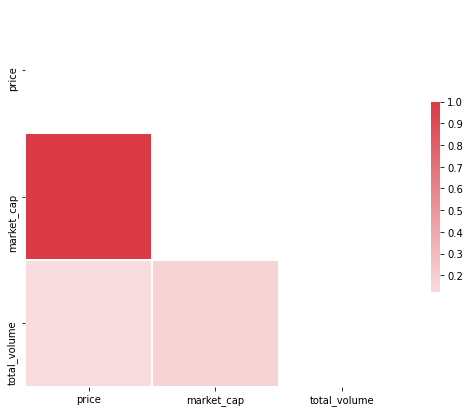

In [64]:
import seaborn as sns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Here we can see that every sample corresponds to a day which is defined by the __day in a date format, the current price, the capital market and the total volume of transactions__ performed that day.

At first glance, the __market_cap__ by itself is a good indicator of the price since it has the highest correlation.

In [65]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [66]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [67]:
features = ['price', 'market_cap', 'total_volume']

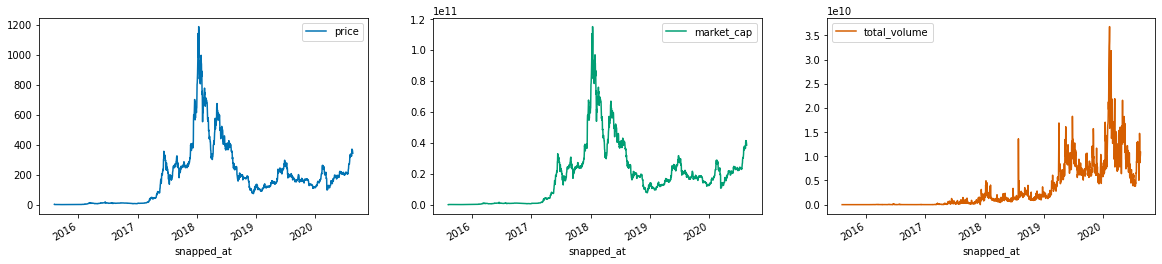

In [68]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

---
### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [69]:
#check
'2015-08-09 00:00:00' in data.index

False

In [70]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

Now, the index is completed but the inexistent samples must be filled out.

#### Find NaN and Fix it

In [71]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [72]:
#Check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [73]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

Now we need to include a new feature which will define the closed price for every sample. Ethereum market is always open so we can forget about weekends and use directly the open price of the next sample.

Afterwards the model will use this __*close_price* as the target__ since it's the value we are trying to predict.

The following script will help us with that.

In [74]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2020-08-16,365.343550,4.092308e+10,8.668263e+09,365.729804
2020-08-17,365.729804,4.103849e+10,1.069973e+10,362.102420
2020-08-18,362.102420,4.063633e+10,9.849998e+09,353.327751
2020-08-19,353.327751,3.968129e+10,1.009743e+10,343.230167
2020-08-20,343.230167,3.852235e+10,1.085197e+10,NaN


In [75]:
#Delete last because we don't know still the closed price 
data = data.drop(data.index[len(data)-1])

#### Final Dataset

In [76]:
# Update the features with the highest correlation
features = ['market_cap']
data = data.drop(['price', 'total_volume'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1840 entries, 2015-08-07 to 2020-08-19
Freq: D
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   market_cap    1840 non-null   float64
 1   closed_price  1840 non-null   float64
dtypes: float64(2)
memory usage: 43.1 KB


----
### Split Data into Training and Test Datasets

In [77]:
# 80% for training, 10% for validation and 10% for testing
idx1 = round(len(data)*0.8)
idx2 = round(len(data)*0.9)
data_train, data_val, data_test = data[:idx1].copy(), data[idx1:idx2].copy(), data[idx2:].copy()

In [78]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_val: {}".format(data_val.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 1472
Size data_val: 184
Size data_test: 184


### Normalizing Datasets

Take care of this because we __don't know if the future values are in the range__. For this reason we'll __fit the scaler using only the training data and NOT the testing data__.

__Standardization__ is a well known normalizer that uses the standard deviation assuming the dataset follows a Gaussian distribution (it's specially robust for new values outside of the expected values).

_*__Note:__ this method assumes the distribution of data fits to Gaussian distribution._

In [79]:
#Scale the data
scaler = StandardScaler()

data_train_norm, data_val_norm, data_test_norm = data_train.copy(), data_val.copy(), data_test.copy()

data_train_norm[data.columns] = scaler.fit_transform(data_train[data.columns])
data_val_norm[data.columns] = scaler.transform(data_val[data.columns])
data_test_norm[data.columns] = scaler.transform(data_test[data.columns])

data_val_norm.describe()

,market_cap,closed_price
count,184.000000,184.000000
mean,-0.018627,-0.090740
std,0.140596,0.130795
min,-0.264148,-0.317357
25%,-0.124438,-0.190133
50%,-0.007871,-0.081761
75%,0.036978,-0.039491
max,0.547374,0.410162


---
## Building the Models

### Check Tensorflow and GPU

In [80]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.3.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


### Sequence Regressor 1-step

In [81]:
FEATURES_LEN = len(data.columns) - 1

In [82]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

X_train = data_train_norm[features].values.reshape((data_train_norm.shape[0], 1, FEATURES_LEN))
y_train = data_train_norm.closed_price.values

X_val = data_val_norm[features].values.reshape((data_val_norm.shape[0], 1, FEATURES_LEN))
y_val = data_val_norm.closed_price.values


In [83]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1472, 1, 1)
(1472,)
(184, 1, 1)
(184,)


In [84]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, FEATURES_LEN) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

Training) R^2 score: 0.991
Validation)  R^2 score: 0.871


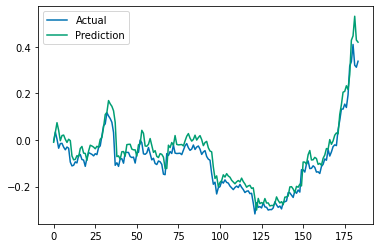

In [85]:
print("Training) R^2 score: {:.3f}".format(r2_score(y_train, model.predict(X_train))))
print("Validation)  R^2 score: {:.3f}".format(r2_score(y_val, model.predict(X_val))))

pred = model.predict(X_val)
plt.plot(y_val, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [86]:
#saving
model_1step = model

### Sequence Regressor 7-steps

In [87]:
'''
Helper function to transform the dataset to
shapes defined by 7 steps and 3 features
'''
def prepare_sequence(data, sequence_size=7):
    sequence = []
    buckets = data.shape[0]//sequence_size
    init_sample = data.shape[0] - buckets*sequence_size
    samples = 0
    for i in range(init_sample, data.shape[0] - sequence_size + 1):
        sequence.append(data[i:i+sequence_size])
        samples += 1
    return np.concatenate(sequence).reshape((samples, sequence_size, data.shape[1]))

prepare_sequence(data[features]).shape

(1828, 7, 1)

In [88]:
#getting (samples, steps, features)
X_train = prepare_sequence(data_train_norm[features])
X_val = prepare_sequence(data_val_norm[features])

y_train = data_train_norm.iloc[-len(X_train):].closed_price.values
y_val = data_val_norm.iloc[-len(X_val):].closed_price.values

In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1464, 7, 1)
(1464,)
(176, 7, 1)
(176,)


In [90]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, FEATURES_LEN) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

Training) R^2 score: 0.990
Validation)  R^2 score: 0.758


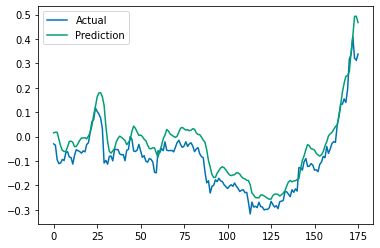

In [91]:
print("Training) R^2 score: {:.3f}".format(r2_score(y_train, model.predict(X_train))))
print("Validation)  R^2 score: {:.3f}".format(r2_score(y_val, model.predict(X_val))))

pred = model.predict(X_val)
plt.plot(y_val, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [92]:
#saving
model_7steps = model

### ⇩ SPECIAL NORMALIZATION FOR SEQUENCES ⇩

The neural network is not able to get good predictions for that data that has not seen before. For that reason we can find day that are not well fitted. This problem is related to the __'out-of-scale'__ data inputs.

#### Custom: window steps by the rate of change ####

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [93]:
def print_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print("mean:{:.3f} std:{:.3f}".format(mean, std))

In [94]:
def window_normalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    normalizer = list()
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]/np.abs(data[j-1])
        normalizer.append(np.abs(data[j-1]))
        #print_mean_std(y[i:j])
        
    return y, normalizer

def window_denormalization(norm_data, normalizer, window_size):
    y = np.empty_like(norm_data, dtype='float64')
    idx = 0
    for i in range(0,len(norm_data), window_size):
        j = min(i+window_size, len(norm_data))
        y[i:j] = norm_data[i:j]*normalizer[idx]
        idx += 1
        
    return y

In [95]:
#testing the function
a = np.array([[1, 1, 1], [2, 2, 2], [2, 2, 2], [8, 8, 8]])
expected_result = np.array([[0.5, 0.5, 0.5], [1, 1, 1], [0.25, 0.25, 0.25], [1, 1, 1]])
norm_a, normalizer = window_normalization(a, 2)

assert ( np.array_equal(norm_a, expected_result) )
assert ( np.array_equal(a, window_denormalization(norm_a, normalizer, 2)) )

In [96]:
#Showing the last sample
data.index[-1].strftime("%d-%m-%Y")

'19-08-2020'

In [97]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train_norm, _ = window_normalization(X_train, window_size)
y_train_norm, y_normalizer = window_normalization(y_train, window_size)

#getting (samples, steps, features)
X_train_norm = prepare_sequence(X_train_norm)
y_train_norm = y_train_norm[-len(X_train_norm):]

In [98]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, FEATURES_LEN) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_norm, y_train_norm, epochs=50, batch_size=window_size, verbose=0)

In [99]:
X_val = data_val[features].values
y_val = data_val.closed_price.values

X_val_norm, _ = window_normalization(X_val, window_size)
y_val_norm, y_scaler = window_normalization(y_val, window_size)

#getting (samples, steps, features)
X_val_norm = prepare_sequence(X_val_norm)
y_val_norm = y_val_norm[-len(X_val_norm):]

Training) R^2 score: 0.914
Validation)  R^2 score: 0.875


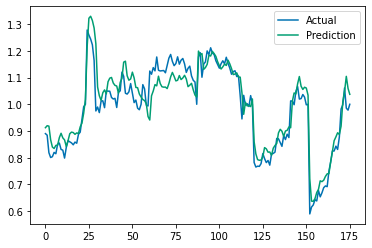

In [100]:
print("Training) R^2 score: {:.3f}".format(r2_score(y_train_norm, model.predict(X_train_norm))))
print("Validation)  R^2 score: {:.3f}".format(r2_score(y_val_norm, model.predict(X_val_norm))))

pred = model.predict(X_val_norm)
plt.plot(y_val_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [101]:
#saving 
model_win = model

---
## Testing the Best Model

Seeing the last results our best chance of accurate predictions (__at a glance__) is to use:

* LSTM sequence by 7 steps
* Data Standardization

In [57]:
X_test = prepare_sequence(data_test_norm[features])
y_test = data_test_norm.iloc[-len(X_test):].closed_price.values

pred = model_7steps.predict(X_test)

# Correction due to sequence of 7 values
data_test_norm = data_test_norm[8:]

In [102]:
X_test = data_test_norm[features].values.reshape((data_test_norm.shape[0], 1, FEATURES_LEN))
y_test = data_test_norm.closed_price.values
pred = model_1step.predict(X_test)

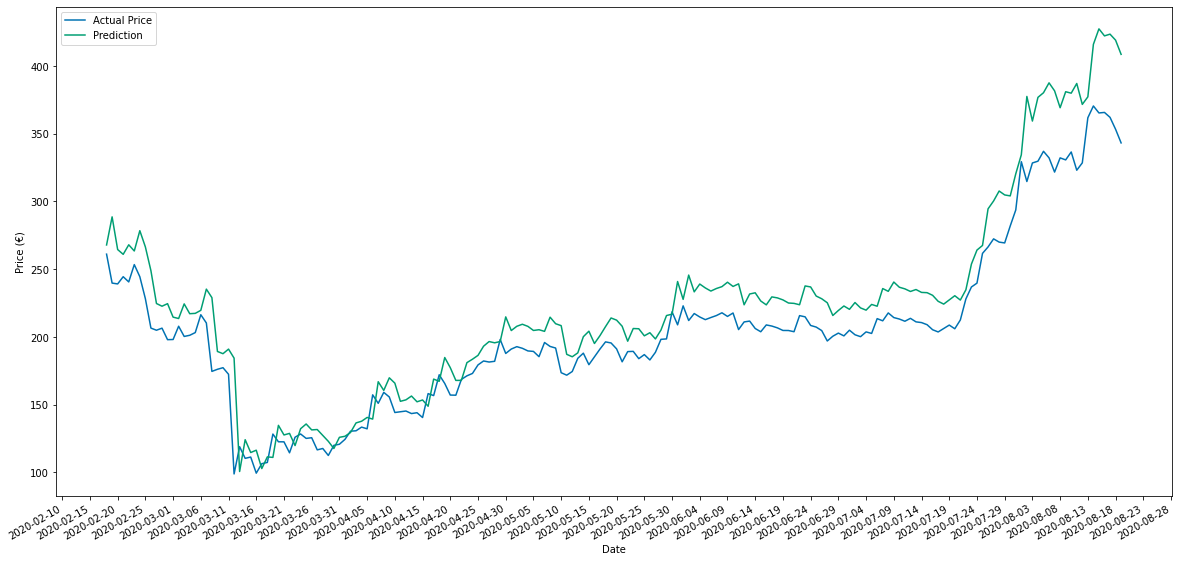

In [103]:
#test_prices = scaler.inverse_transform(data_test_norm[8:])
test_prices = scaler.inverse_transform(data_test_norm)
pred_prices = test_prices.copy()
pred_prices[:, FEATURES_LEN] = pred.reshape(-1)
pred_prices = scaler.inverse_transform(pred_prices)

plt.figure(figsize=(20,10))
plt.plot(data_test_norm.index, test_prices[:, FEATURES_LEN], label='Actual Price')
plt.plot(data_test_norm.index, pred_prices[:, FEATURES_LEN], label='Prediction')
plt.ylabel('Price (€)')
plt.xlabel('Date')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate()